In [1]:
from matplotlib import ticker

from detection.training import collate_fn, CraterEllipseDataset
from src.detection.evaluate import Evaluator
import torch
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
from astropy.coordinates import cartesian_to_spherical

from matplotlib import ticker

In [ ]:
ev = Evaluator(device="cuda")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for iou_threshold in torch.arange(start=0.5, end=0.99, step=0.10):
    precision, recall, f1, iou, dist, confidence_thresholds = ev.performance_metrics(iou_threshold=iou_threshold)

    R = torch.cat((torch.ones(1), recall.cpu(), torch.zeros(1)))
    P = torch.cat((torch.zeros(1), precision.cpu(), torch.ones(1)))

    AUC = torch.trapz(R, P)

    ax.fill_between(R, P, alpha=0.2, step='pre')
    ax.step(R, P, label=f'IoU>{iou_threshold:.2f} | AUC={AUC:.3f}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.05))
ax.set_ylim((0, 1.05))
ax.legend()

In [ ]:
# fig.savefig("output/precision_recall_curve.pdf")

In [ ]:
_, _, _, _, dist, confidence_thresholds = ev.performance_metrics(iou_threshold=0.5)

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(confidence_thresholds.cpu(), dist.cpu(), 'r-x')
ax2.set_xlabel('Confidence Threshold $t_p$')
ax2.set_ylabel('Ellipse Divergence $d_{GA}$')
ax2.grid()

In [ ]:
fig2.savefig('output/confidence_divergence_curve.pdf')

In [1]:
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from common.conics import plot_conics
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from src.common.conics import *

In [2]:
db = CraterDatabase.from_file(latlims=(0, 30), longlims=(0, 30), diamlims=(5, 25), radius=200)
generator = DataGenerator.from_robbins_dataset(diamlims=(5, 40))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [ ]:
n_rows, n_cols = 1, 4
n_demo = n_rows * n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

k = 0
generator.set_coordinates(
    -12.5,
    -3.5,
    300,
    convert_to_radians=True,
    point_nadir=True
)
generator.scene_time = dt.datetime(2021, 1, 5)
generator.height = 300
C_craters, r_craters = generator.visible_catalogue_craters(None)
a, b = ellipse_axes(C_craters)
C_craters, r_craters = C_craters[a > 20], r_craters[a > 20]
idxs = np.random.choice(np.arange(len(r_craters)), 3)
C_craters, r_craters = C_craters[[5, 6, 8]], r_craters[[5, 6, 8]]

features = np.zeros((n_cols, 7))
for col in range(n_cols):

    generator.point_nadir()
    generator.rotate('roll', np.random.randint(0, 360))
    generator.rotate('pitch', np.random.randint(-30, 30))
    generator.rotate('yaw', np.random.randint(-30, 30))
    # generator.height = 300 + col*100
    print(generator.height)

    A_craters = generator.project_crater_conics(C_craters, r_craters)

    image = generator.generate_image()
    plot_conics(A_craters, ax=axes[col], rim_color='cyan')

    axes[col].imshow(image, cmap='gray')
    axes[col].axis("off")
    axes[col].set_title(k)

    features[col] = CoplanarInvariants.from_detection_conics(A_craters).get_pattern()

    k += 1
features

In [ ]:
(features / features).mean(0)

In [ ]:
n_test = 5000
sigma_pix = 1
sigma_centre = 1
features_delta = np.zeros((n_test, 7))
for i in range(n_test):
    generator.set_random_position()
    generator.point_nadir()
    generator.rotate('roll', np.random.randint(0, 360))
    generator.rotate('pitch', np.random.randint(-30, 30))
    generator.rotate('yaw', np.random.randint(-30, 30))
    generator.height = np.random.uniform(150, 400)

    A_craters = generator.craters_in_image()
    if len(A_craters) > 3:
        if len(A_craters) > 20:
            idxs = np.random.default_rng().choice(20, 10, replace=False)
            A_craters = A_craters[idxs]
        invariants = CoplanarInvariants.from_detection_conics(A_craters)
        pattern = invariants.get_pattern()
        crater_triads = invariants.crater_triads


        n_det = len(A_craters)
        # Add noise
        major_det, minor_det = ellipse_axes(A_craters)
        psi_det = ellipse_angle(A_craters)
        r_craters_det = conic_center(A_craters)

        major_det += np.random.normal(0, sigma_pix, size=n_det)
        minor_det += np.random.normal(0, sigma_pix, size=n_det)
        psi_det += np.random.uniform(-(10/180)*np.pi, (10/180)*np.pi)
        r_craters_det += np.random.normal(0, sigma_centre, size=r_craters_det.shape)

        A_craters_noisy = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)
        A_i, A_j, A_k = np.array(list(map(lambda vertex: A_craters_noisy[vertex], crater_triads.T)))
        pattern_noisy = CoplanarInvariants(crater_triads, A_i, A_j, A_k).get_pattern()

        features_delta[i] = ((pattern - pattern_noisy)/pattern).mean(0)

In [ ]:
features_delta[:, 3:6]

In [ ]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(features_delta[:, :3].mean(1)*100, range=(-50, 50), bins=50, color='red')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].set_xlabel("$\{\Delta I_{ij}, \Delta I_{jk}, \Delta I_{ki}\}$")
axes[1].hist(features_delta[:, 3:6].mean(1)*100, range=(-50, 50), bins=50, color='blue')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].set_xlabel("$\{\Delta I_{ji}, \Delta I_{kj}, \Delta I_{ik}\}$")
axes[2].hist(features_delta[:, 6]*100, range=(-50, 50), bins=50, color='purple')
axes[2].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[2].set_xlabel("$\Delta I_{ijk}$")

In [ ]:
fig.tight_layout()
# fig.savefig("output/invariants_monte_carlo.pdf")

In [1]:
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from src.common.conics import *
from src import CraterDetector
import torch
from tqdm.auto import tqdm as tq

In [2]:
db = CraterDatabase.from_file("data/lunar_crater_database_robbins_2018.csv",
                              latlims=(0, 30),
                              longlims=(0, 30),
                              diamlims=(5, 40),
                              radius=200,
                              )

In [3]:
cam = DataGenerator.from_robbins_dataset(file_path="data/lunar_crater_database_robbins_2018.csv", diamlims=(4, 40), axis_threshold=(1, 250))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [4]:
cda = CraterDetector()
cda.load_state_dict(torch.load("blobs/CraterRCNN.pth"))
cda.to('cuda')
cda.eval()
print()

In [7]:
n_trials = 1
test_size = 50000

attitude_test = np.empty((n_trials, test_size, 3, 3), np.float64)
true_position_test = np.full((n_trials, test_size, 3, 1), np.nan, np.float64)
pred_ransac_test = np.full((n_trials, test_size, 3, 1), np.nan, np.float64)
pred_reprojection_test = np.full((n_trials, test_size, 3, 1), np.nan, np.float64)
n_detections_test = np.zeros((n_trials, test_size))
n_inliers_test = np.zeros((n_trials, test_size))
n_verified_test = np.zeros((n_trials, test_size))
sun_angle_test = np.zeros((n_trials, test_size))
pitch_angle_test = np.zeros((n_trials, test_size))
yaw_angle_test = np.zeros((n_trials, test_size))

match_stats = np.zeros((n_trials))
error_stats = np.zeros((n_trials))
trial_args = []

for trial in range(n_trials):
    matches = 0
    errors = 0
    latest_position_error = 0.
    match_trial_args = dict(
        sigma_pix=5,
        k=30,
        max_distance=0.045,
        batch_size=2000,
        residual_threshold=0.020,
        max_trials=1500
    )
    trial_args.append(match_trial_args)
    bar = tq(range(test_size), postfix={"matches": 0, "errors": 0, "latest_position_error": 0.})
    for i in bar:
        n_det = 0
        while n_det < 10:
            cam.set_coordinates(np.random.uniform(5, 25), np.random.uniform(5, 25))
            cam.height = np.random.uniform(100, 250)
            cam.point_nadir()
            cam.rotate('roll', np.random.uniform(0, 360))
            pitch = np.random.uniform(-10, 10)
            cam.rotate('pitch', pitch)
            yaw = np.random.uniform(-10, 10)
            cam.rotate('yaw', yaw)
            A_craters = cam.craters_in_image()
            n_det = len(A_craters)

        image = cam.generate_image()
        image = torch.as_tensor(image[None, None, ...]).to('cuda')
        with torch.no_grad():
            pred = cda(image)[0]

        scores = pred['scores']
        A_detections = pred['ellipse_matrices'][scores > 0.75].cpu().numpy()

        attitude_test[trial, i] = cam.attitude
        true_position_test[trial, i] = cam.position
        sun_angle_test[trial, i] = cam.solar_incidence_angle
        pitch_angle_test[trial, i] = pitch
        yaw_angle_test[trial, i] = yaw
        n_detections_test[trial, i] = n_det

        if len(A_detections) < 6:
            continue
        try:
            position_regressor = db.query_position(A_detections, T=cam.T, K=cam.K,
                                                   **match_trial_args)
            if position_regressor.ransac_match():
                pred_ransac_test[trial, i] = position_regressor.est_pos_ransac
                n_inliers_test[trial, i] = position_regressor.num_inliers
                # print(f"[{i:05}]\tRANSAC position error: {LA.norm(position_regressor.est_pos_ransac - cam.position)*1000:12.2f} m\t"
                #       f"| Inliers: {position_regressor.num_inliers}", end= "\t")

                if position_regressor.reprojection_match():
                    pred_reprojection_test[trial, i] = position_regressor.est_pos_verified
                    n_verified_test[trial, i] = position_regressor.num_verified
                    # print(f"Verified position error:  {LA.norm(position_regressor.est_pos_verified - cam.position)*1000:12.2f} m", end="")
                    latest_position_error = LA.norm(position_regressor.est_pos_verified - cam.position)
                    if latest_position_error < 20:
                        matches += 1
                    else:
                        errors += 1

        except ValueError:
            errors += 1

        bar.set_postfix(ordered_dict={"matches": matches, "errors": errors, "latest_position_error": latest_position_error})

    match_stats[trial] = matches
    error_stats[trial] = errors


  0%|          | 0/50000 [00:00<?, ?it/s, errors=0, latest_position_error=0, matches=0]

C:\dev\workspace\crater-detection\src\detection\metrics.py:229: RuntimeWarning: invalid value encountered in sqrt
  frac_term = (4 * np.sqrt(LA.det(cov1) * LA.det(cov2)) / (LA.det(cov1 + cov2)))
C:\dev\workspace\crater-detection\src\detection\metrics.py:230: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-0.5 * (m1 - m2).transpose(0, 2, 1) @ cov1 @ LA.inv(cov1 + cov2) @ cov2 @ (m1 - m2)).squeeze()
C:\dev\workspace\crater-detection\src\common\conics.py:135: RuntimeWarning: invalid value encountered in sqrt
  axes = np.sqrt(1 / lambdas)
C:\dev\workspace\crater-detection\src\detection\metrics.py:229: RuntimeWarning: invalid value encountered in sqrt
  frac_term = (4 * np.sqrt(LA.det(cov1) * LA.det(cov2)) / (LA.det(cov1 + cov2)))
C:\dev\workspace\crater-detection\src\detection\metrics.py:230: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-0.5 * (m1 - m2).transpose(0, 2, 1) @ cov1 @ LA.inv(cov1 + cov2) @ cov2 @ (m1 - m2)).squeeze()
C:\dev\workspace\crater-

In [6]:
inlier_positions = np.logical_and.reduce(~np.isnan(pred_ransac_test), axis=(1,2))
err_inliers = LA.norm(pred_ransac_test[inlier_positions] - true_position_test[inlier_positions], axis=1).ravel()*1000
verified_positions = np.logical_and.reduce(~np.isnan(pred_reprojection_test), axis=(1,2))
err_verified = LA.norm(pred_reprojection_test[verified_positions] - true_position_test[verified_positions], axis=1).ravel()*1000
bins = np.arange(0, 5000, 200)
fig, ax = plt.subplots(figsize=(8, 4), sharex='all', sharey='all')

ax.hist(err_verified, bins=bins, color='red', alpha=0.7)
ax.set_xlabel("$||\Delta \mathbf{x}||_2$")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))

fig.tight_layout()
fig.savefig("output/system_total_error.pdf")
len(err_inliers), len(err_verified)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 25000 but corresponding boolean dimension is 1

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), sharex='all', sharey='all')


for pred, true, color in zip([pred_reprojection_test[verified_positions]],
                                 [true_position_test[verified_positions]],
                                 ['red']):
    err_r, err_lat_rad, err_lon_rad = np.array(cartesian_to_spherical(*pred.squeeze().T) -
                                               np.array(cartesian_to_spherical(*true.squeeze().T)))

    err_lat, err_lon = map(np.degrees, (err_lat_rad, err_lon_rad))

    err_lon[err_lon > 180] -= 360


    ax.hist(err_r*1000, bins=np.arange(-5000, 5000,200), color=color, alpha=0.7)
ax.set_xlabel(r'$\Delta r$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))
fig.tight_layout()
fig.savefig("output/system_radial_error.pdf")

In [ ]:
err_r, err_lat_rad, err_lon_rad = np.array(cartesian_to_spherical(*(pred).squeeze().T) -
                                           np.array(cartesian_to_spherical(*(true).squeeze().T)))

err_lat, err_lon = map(np.degrees, (err_lat_rad, err_lon_rad))
fig, ax = plt.subplots(figsize=(8, 6))
err_range = np.arange(-1000, 1000, 100)
h = ax.hist2d(LA.norm(true_position_test[verified_positions], axis=(1,2)) * err_lon_rad * 1e3,
              LA.norm(true_position_test[verified_positions], axis=(1,2)) * err_lat_rad * 1e3,
              bins=err_range, cmap='viridis')
ax.set_xlabel(r'$\Delta x_{\lambda}$')
ax.set_ylabel(r'$\Delta x_{\varphi}$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
plt.colorbar(h[3], ax=ax)
fig.tight_layout()
fig.savefig("output/system_coordinate_error.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
err_range = np.arange(-0.25, 0.25, 0.01)
h = ax.hist2d(err_lon, err_lat, bins=err_range, cmap='viridis')
ax.set_xlabel(r'$\Delta \lambda$')
ax.set_ylabel(r'$\Delta \varphi$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
plt.colorbar(h[3], ax=ax)
fig.tight_layout()
fig.savefig("output/system_coordinate_error_degrees.pdf")

In [ ]:
err_x, err_y, err_z = ((pred_reprojection_test[verified_positions] - true_position_test[verified_positions])*1000).squeeze().T
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

err_range = np.arange(-6000, 6000, 200)

h = ax[0, 0].hist2d(err_x, err_y, bins=err_range, cmap='viridis')
ax[0, 0].set_xlabel('$\Delta X$')
ax[0, 0].set_ylabel('$\Delta Y$')

ax[1, 0].hist2d(err_x, err_z, bins=err_range, cmap='viridis')
ax[1, 0].set_xlabel('$\Delta X$')
ax[1, 0].set_ylabel('$\Delta Z$')

ax[0, 1].hist2d(err_y, err_z, bins=err_range, cmap='viridis')
ax[0, 1].set_xlabel('$\Delta Y$')
ax[0, 1].set_ylabel('$\Delta Z$')

ax[1, 1].axis('off')
# plt.colorbar(h[3], ax=ax[1, 1])
np.nanmean(err_x)

In [ ]:
dist_filter = err_verified < 20e3
fig, ax = plt.subplots(figsize=(12, 6))
n = n_verified_test[verified_positions][dist_filter]
e = err_verified[dist_filter]
data = []
ticklabels = []
medians = []
for i, c in zip(*np.unique(n_verified_test, return_counts=True)):
    if c < 20 or i <= 2:
        continue
    data.append(e[n == i])
    ticklabels.append(int(i))
    medians.append(np.median(e[n == i]))

ax.boxplot(data, positions=ticklabels)
ax.plot(ticklabels, medians)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.set_xlabel("Verified matches")
ax.set_ylabel("$||\Delta \mathbf{x}||_2$")
fig.tight_layout()
fig.savefig("output/system_verification_accuracy_boxplot.pdf")


In [ ]:
dist_filter = err_verified < 20e3
fig, ax = plt.subplots(figsize=(12, 6))
n = n_verified_test[verified_positions][dist_filter]
data = []
ticklabels = []
medians = []

height_levels = np.arange(50, 201, 25)

for h_min, h_max in zip(height_levels[:-1], height_levels[1:]):

    h = LA.norm(true_position_test[verified_positions][dist_filter], axis=(1,2))
    f = np.logical_and(h_min < (h - const.RMOON), (h-const.RMOON) < h_max)
    if f.sum() < 20:
        continue
    d = err_verified[dist_filter][f]
    medians.append(np.median(d))

    data.append(d)
    ticklabels.append(f"{h_min}km - {h_max}km")

box_altitude = ax.boxplot(data)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.set_xticklabels(ticklabels)
ax.set_xlabel("Altitude ranges")
ax.set_ylabel("$||\Delta \mathbf{x}||_2$")
fig.tight_layout()
fig.savefig("output/system_altitude_accuracy_boxplot.pdf")

In [ ]:
import pandas as pd
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)
    out = pd.DataFrame(rows_list)
    return out
get_box_plot_data(ticklabels, box_altitude)

In [ ]:
dist_filter = err_verified < 20e3
fig, ax = plt.subplots(figsize=(12, 6))
n = n_verified_test[verified_positions][dist_filter]
data = []
ticklabels = []
medians = []

sun_angle_range = np.arange(10, 81, 5)

for ang_min, ang_max in zip(sun_angle_range[:-1], sun_angle_range[1:]):

    ang = sun_angle_test[verified_positions][dist_filter]
    f = np.logical_and(ang > ang_min, ang < ang_max)
    if f.sum() < 5:
        continue
    d = err_verified[dist_filter][f]
    medians.append(np.median(d))

    data.append(d)
    ticklabels.append(f"${ang_min}^{{\circ}} - {ang_max}^{{\circ}}$")

box_sun_angle = ax.boxplot(data)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.set_xticklabels(ticklabels)
ax.set_xlabel("Solar incidence angle")
ax.set_ylabel("$||\Delta \mathbf{x}||_2$")
fig.tight_layout()
fig.savefig("output/system_sun_angle_accuracy_boxplot.pdf")
get_box_plot_data(ticklabels, box_sun_angle)

In [ ]:
horizontal_error = LA.norm(np.vstack((LA.norm(true_position_test[verified_positions][dist_filter], axis=(1,2)) * err_lon_rad[dist_filter] * 1e3,
    LA.norm(true_position_test[verified_positions][dist_filter], axis=(1,2)) * err_lat_rad[dist_filter] * 1e3)), axis=0)
np.median(horizontal_error)

In [11]:
# np.save("output/arrays/attitude_test.npy", attitude_test)
# np.save("output/arrays/true_position_test.npy", true_position_test)
# np.save("output/arrays/pred_ransac_test.npy", pred_ransac_test)
# np.save("output/arrays/pred_reprojection_test.npy", pred_reprojection_test)
# np.save("output/arrays/n_detections_test.npy", n_detections_test)
# np.save("output/arrays/n_inliers_test.npy", n_inliers_test)
# np.save("output/arrays/n_verified_test.npy", n_verified_test)
# np.save("output/arrays/sun_angle_test.npy", sun_angle_test)
# np.save("output/arrays/pitch_angle_test.npy", pitch_angle_test)
# np.save("output/arrays/yaw_angle_test.npy", yaw_angle_test)
# np.save("output/arrays/match_stats.npy", match_stats)
# np.save("output/arrays/error_stats.npy", error_stats)

In [12]:
# import json
# with open("output/arrays/trial_args.json", "w") as f:
#     json.dump(trial_args, f)

In [30]:
n_det = 0
while n_det < 10:
    cam.set_coordinates(np.random.uniform(5, 25), np.random.uniform(5, 25))
    cam.height = np.random.uniform(50, 200)
    cam.point_nadir()
    cam.rotate('roll', np.random.uniform(0, 360))
    pitch = np.random.uniform(-30, 30)
    cam.rotate('pitch', pitch)
    yaw = np.random.uniform(-30, 30)
    cam.rotate('yaw', yaw)
    A_craters = cam.craters_in_image()
    n_det = len(A_craters)

In [31]:
cam.latitude, cam.longitude, cam.height

(9.819353591990478, 11.657400666998985, 188.00033557138954)

No sunlight!
70.93002438120358
47.16247079413267
24.171832567156535
10.540082188219857
28.35263829782327
51.59272916055485
75.39194583877031


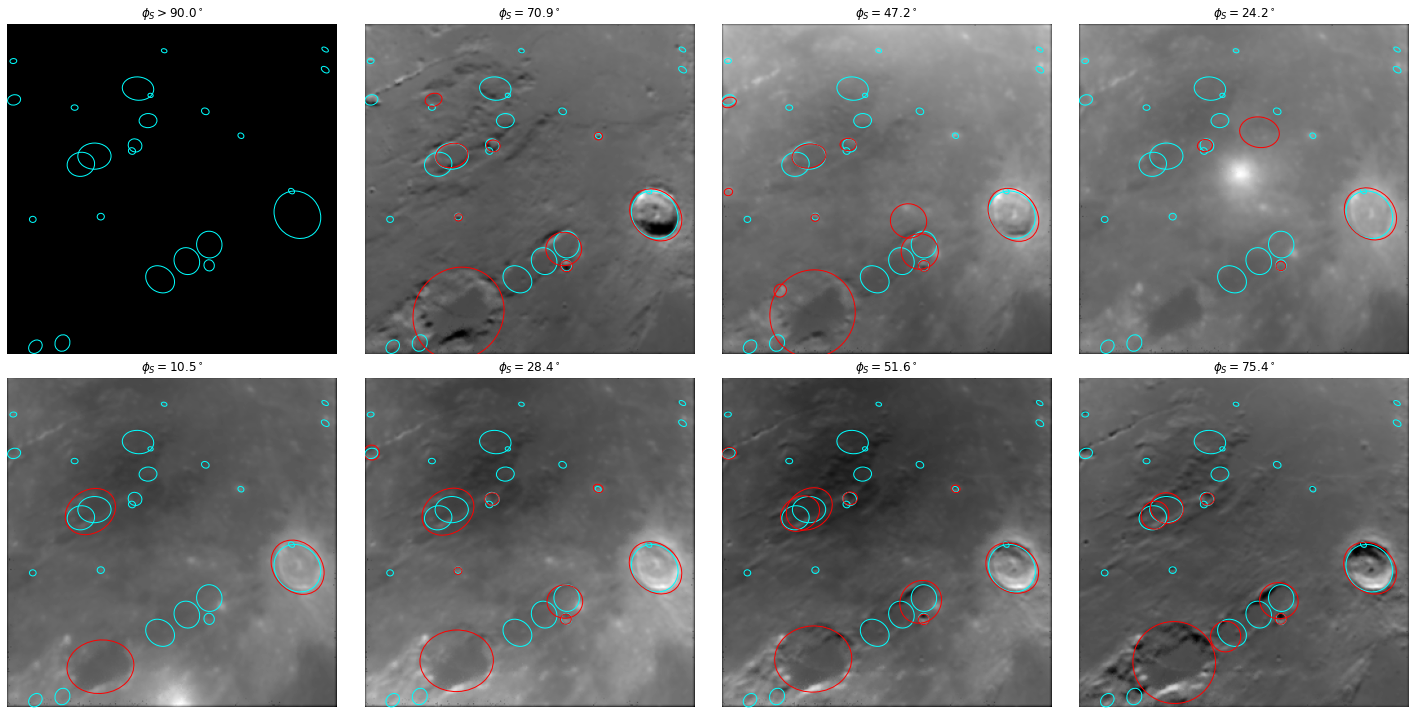

In [32]:
import datetime as dt

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
cam.scene_time = dt.datetime(2020, 12, 19, 0)
cam.point_nadir()
cam.rotate('roll', -90)
cam.rotate('pitch', 20)
cam.rotate('yaw', 10)
cam.height = 250
for i, ax_ in enumerate(axes):
    for j, ax in enumerate(ax_):
        cam.scene_time = cam.scene_time + dt.timedelta(2)
        image = cam.generate_image()
        with torch.no_grad():
            if image.sum() != 0.0:
                pred = cda( torch.as_tensor(image[None, None, ...]).to('cuda'))[0]
                scores = pred['scores']
                A_detections = pred['ellipse_matrices'][scores > 0.75].cpu().numpy()
                sun_angle = cam.solar_incidence_angle
                ax.set_title(f"$\phi_S = {sun_angle:.1f}^\circ$")
                print(sun_angle)
            else:
                A_detections = np.zeros((0, 3, 3))
                ax.set_title(f"$\phi_S >90.0^\circ$")
                print("No sunlight!")

        ax.imshow(image, cmap='gray')
        ax.axis('off')
        plot_conics(cam.craters_in_image(), ax=ax, rim_color='cyan')
        plot_conics(A_detections, ax=ax)

fig.tight_layout()
# fig.savefig("output/sun_angle_demo.pdf")

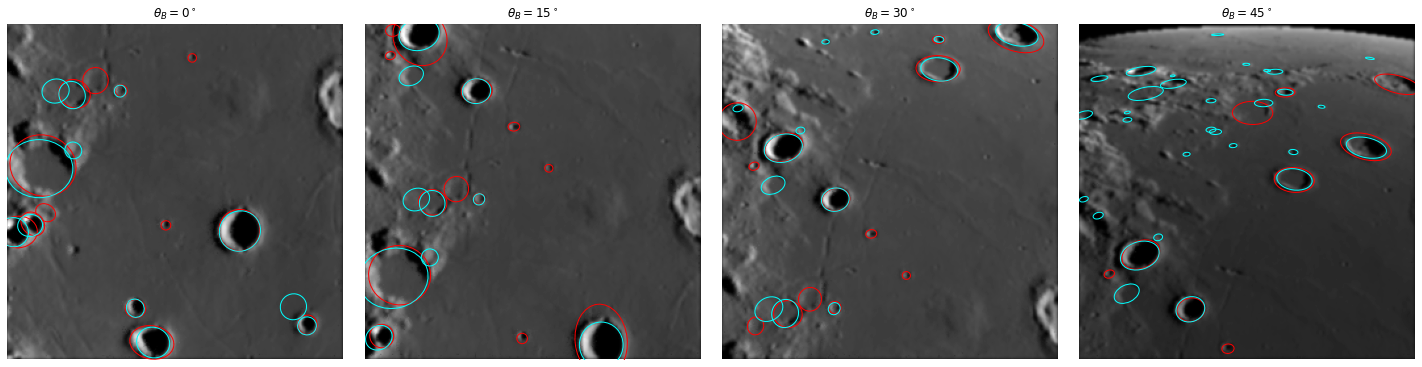

In [84]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
cam.scene_time = dt.datetime(2020, 12, 21, 12)

pitch_delta = 15

for i, ax in enumerate(axes):
    cam.point_nadir()
    cam.rotate('roll', 0)
    cam.rotate('pitch', i*pitch_delta)
    image = cam.generate_image()
    with torch.no_grad():
        if image.sum() != 0.0:
            pred = cda( torch.as_tensor(image[None, None, ...]).to('cuda'))[0]
            scores = pred['scores']
            A_detections = pred['ellipse_matrices'][scores > 0.75].cpu().numpy()
            sun_angle = cam.solar_incidence_angle
            ax.set_title(fr"$\theta_B = {i*pitch_delta:.0f}^\circ$")
        else:
            A_detections = np.zeros((0, 3, 3))
            print("No sunlight!")

    ax.imshow(image, cmap='gray')
    ax.axis('off')
    plot_conics(cam.craters_in_image(), ax=ax, rim_color='cyan')
    plot_conics(A_detections, ax=ax)

fig.tight_layout()
# fig.savefig("output/pitch_angle_demo.pdf")

In [93]:
from src import CraterDetector
from src.common.conics import ellipse_axes, conic_center
from src.detection.metrics import get_matched_idxs
from detection.training import collate_fn, CraterEllipseDataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm as tq
import numpy as np
import torch

ds = CraterEllipseDataset(file_path="data/dataset_crater_detection_80k.h5", group="test")
loader = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

cda = CraterDetector()
cda.load_state_dict(torch.load("blobs/CraterRCNN.pth"))
cda.to('cuda')
cda.eval()

bar = tq(loader, desc=f"Testing")
confidence = 0.75

axis_error = torch.zeros((len(loader), loader.batch_size, 2))
position_error = torch.zeros((len(loader), loader.batch_size, 2))
max_axis = 0
min_axis = 100
max_detections = 0
with torch.no_grad():
    for batch, (images, targets_all) in enumerate(bar):
        images = list(image.to('cuda') for image in images)
        targets_all = [{k: v.to('cuda') for k, v in t.items()} for t in targets_all]

        pred_all = cda(images)

        for i, (pred, targets) in enumerate(zip(pred_all, targets_all)):
            confidence_mask = pred['scores'] > confidence
            if confidence_mask.sum() == 0:
                continue

            matched_idxs, matched = get_matched_idxs(pred['boxes'][confidence_mask].cpu(), targets['boxes'].cpu())
            if matched.sum() == 0:
                continue
            a_pred_true, b_pred_true = ellipse_axes(pred['ellipse_matrices'][confidence_mask][matched])
            a_matched, b_matched = ellipse_axes(targets['ellipse_matrices'][matched_idxs][matched])

            x_pred_true, y_pred_true = conic_center(pred['ellipse_matrices'][confidence_mask][matched]).T
            x_matched, y_matched = conic_center(targets['ellipse_matrices'][matched_idxs][matched]).T

            if torch.hstack((a_pred_true, b_pred_true)).min() < min_axis:
                min_axis = torch.hstack((a_pred_true, b_pred_true)).min()
            if torch.hstack((a_pred_true, b_pred_true)).max() > max_axis:
                max_axis = torch.hstack((a_pred_true, b_pred_true)).max()

            if confidence_mask.sum() > max_detections:
                max_detections = confidence_mask.sum()

            diff_a = ((a_matched - a_pred_true)).abs().mean()
            diff_b = ((b_matched - b_pred_true)).abs().mean()
            axis_error[batch, i] = torch.hstack((diff_a, diff_b))

            diff_x = ((x_matched - x_pred_true)).abs().mean()
            diff_y = ((y_matched - y_pred_true)).abs().mean()
            position_error[batch, i] = torch.hstack((diff_x, diff_y))


Testing:   0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
axis_error.mean(), axis_error.std()

(tensor(2.5537), tensor(1.7977))

In [5]:
position_error.mean(), position_error.std()

(tensor(0.9125), tensor(0.5934))

In [6]:
min_axis, max_axis

(tensor(4.6417, device='cuda:0'), tensor(165.0760, device='cuda:0'))

In [96]:
max_detections

tensor(56, device='cuda:0')

In [3]:
db

In [42]:
from sklearn.neighbors import KDTree

tree = KDTree(db._features, metric='euclidean')
crater_triads, features = next(CoplanarInvariants.match_generator(
    A_craters=A_detections,
    max_iter=1,
    batch_size=10
))
dist, idx = tree.query(features, k=10)

In [1]:

import scipy
scipy.__version__

'1.6.3'